In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('metal.csv', index_col=['date'])
prices.head(10)

TATASTEEL.NS  HINDALCO.NS  JSWSTEEL.NS  ADANIENT.NS     VEDL.NS  \
date                                                                          
01-01-2018    688.066406   271.149994   265.799988    90.480850  325.450012   
02-01-2018    694.830810   271.899994   264.549988    89.309311  327.750000   
03-01-2018    700.213806   276.500000   268.700012    96.011597  332.500000   
04-01-2018    724.318054   279.799988   277.149994    99.880394  339.100006   
05-01-2018    734.274109   276.399994   285.100006   105.247673  339.549988   
08-01-2018    732.416321   276.149994   286.000000   107.045845  340.250000   
09-01-2018    735.798523   271.500000   284.000000   106.746147  337.700012   
10-01-2018    736.322510   268.799988   282.799988   108.326363  334.799988   
11-01-2018    734.512329   267.750000   282.549988   109.906578  333.899994   
12-01-2018    733.845398   268.850006   286.799988   108.953003  339.549988   

            COALINDIA.NS    SAIL.NS  JINDALSTEL.NS     NMDC.NS  APLAPOLLO.NS  
date                                                                          
01-01-2018    266.649994  92.699997     206.199997  141.050003    198.059998  
02-01-2018    270.049988  91.849998     203.399994  148.600006    198.014999  
03-01-2018    271.850006  93.800003     219.550003  149.250000    211.110001  
04-01-2018    277.799988  97.900002     244.550003  154.750000    229.990005  
05-01-2018    278.750000  97.400002     239.050003  158.550003    228.979996  
08-01-2018    287.450012  98.800003     256.450012  161.850006    228.110001  
09-01-2018    304.049988  97.949997     248.750000  154.699997    224.845001  
10-01-2018    308.299988  98.449997     262.399994  155.300003    221.845001  
11-01-2018    308.100006  98.500000     267.350006  155.350006    218.059998  
12-01-2018    309.000000  98.650002     264.850006  154.949997    222.729996

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

TATASTEEL.NS  HINDALCO.NS  JSWSTEEL.NS  ADANIENT.NS     VEDL.NS  \
date                                                                          
01-01-2018    688.066406   271.149994   265.799988    90.480850  325.450012   
02-01-2018    694.830810   271.899994   264.549988    89.309311  327.750000   
30-12-2020    640.450012   237.399994   386.100006   484.149994  162.050003   
31-12-2020    643.650024   240.550003   387.200012   479.549988  161.399994   

            COALINDIA.NS    SAIL.NS  JINDALSTEL.NS     NMDC.NS  APLAPOLLO.NS  
date                                                                          
01-01-2018    266.649994  92.699997     206.199997  141.050003    198.059998  
02-01-2018    270.049988  91.849998     203.399994  148.600006    198.014999  
30-12-2020    135.600006  69.750000     265.950012  115.900002    417.674988  
31-12-2020    135.449997  74.099998     266.450012  114.449997    441.500000

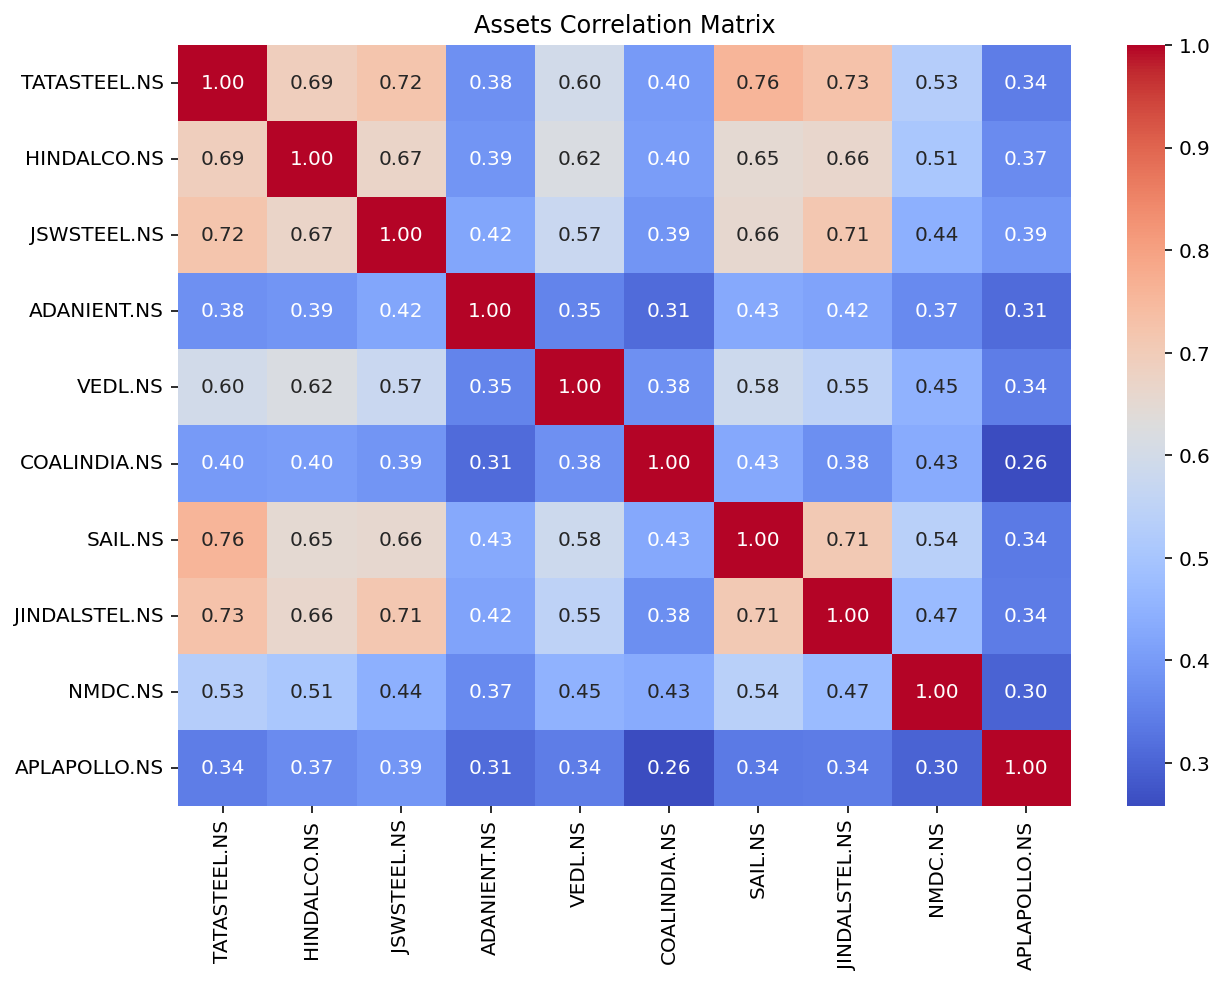

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('TATASTEEL.NS', 'JSWSTEEL.NS'), ('HINDALCO.NS', 'JSWSTEEL.NS')]


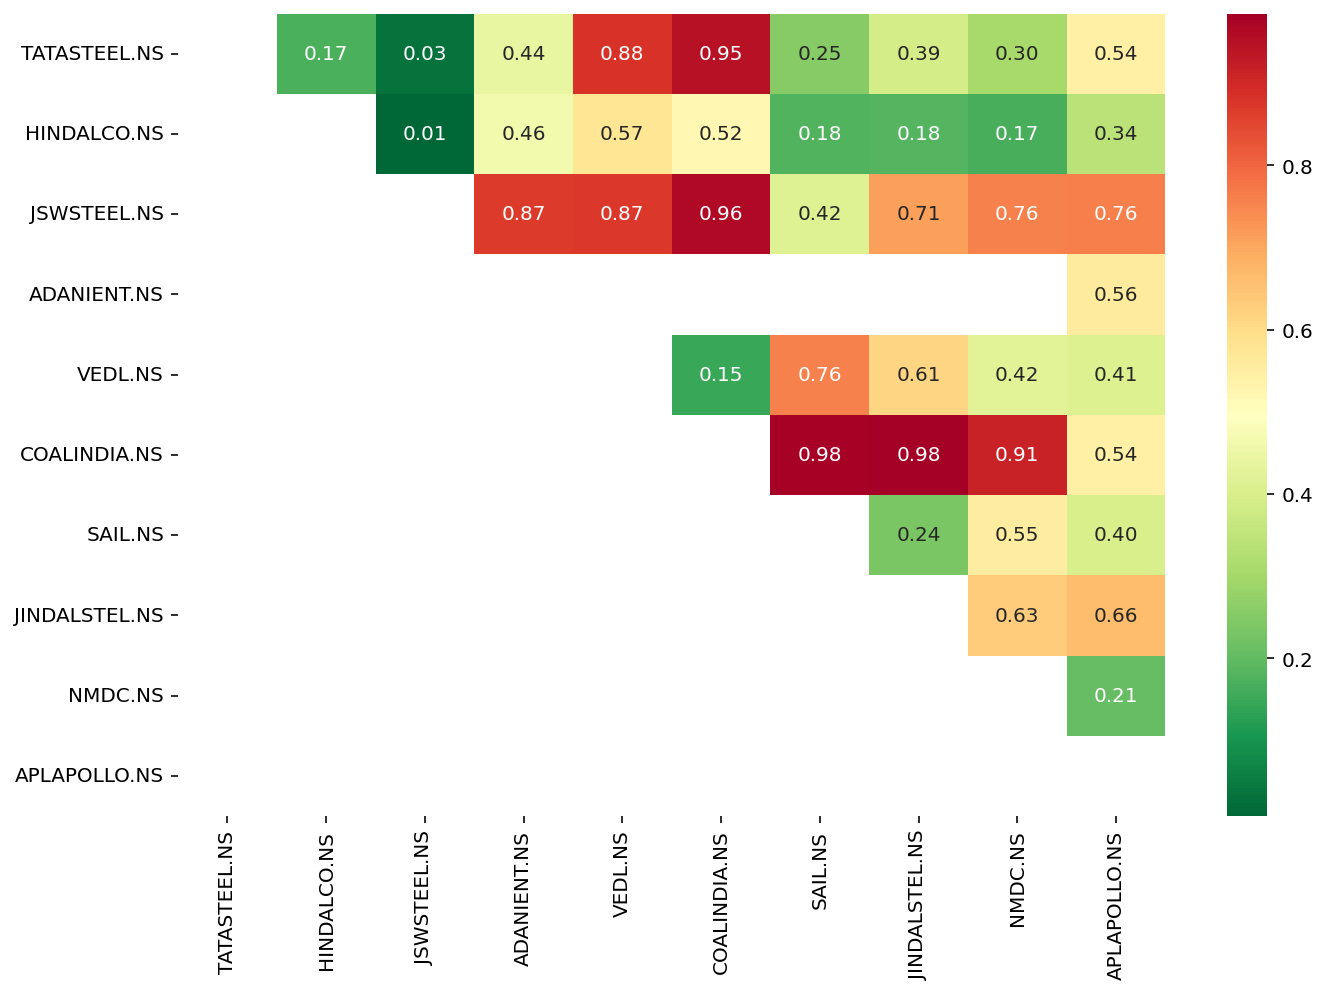

In [8]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
#ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [9]:
# final pair to test strategy
asset1 = 'HINDALCO.NS'
asset2 = 'JSWSTEEL.NS'

In [10]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

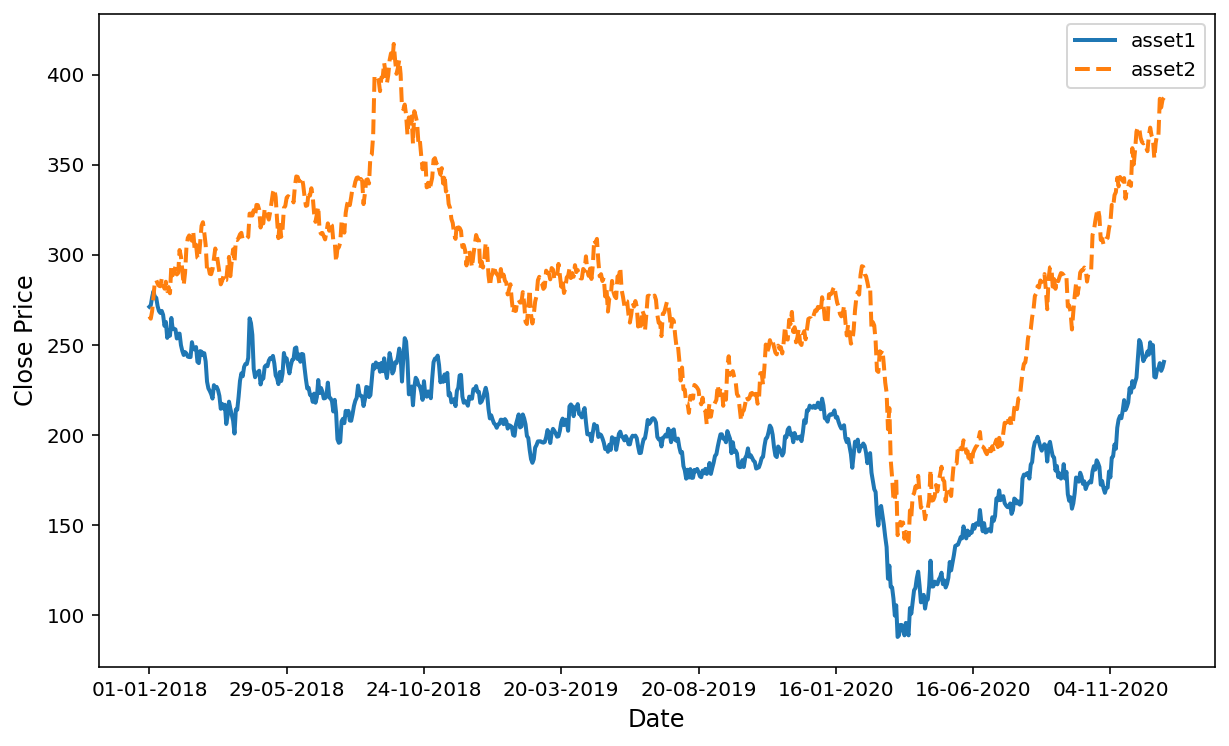

In [12]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1']].plot(figsize=(10, 6), linewidth=2,linestyle='solid', label = "asset1")
plt.plot(train[['asset2']], linewidth=2, linestyle='dashed', label = "asset2")
ax.set_ylabel("Close Price", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
plt.legend()
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
#ax.grid(True);
plt.savefig('chart3', dpi=500) 

In [13]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          5.742e+04
Date:                Thu, 12 May 2022   Prob (F-statistic):                        0.00
Time:                        16:26:25   Log-Likelihood:                         -3617.5
No. Observations:                 740   AIC:                                      7237.
Df Residuals:                     739   BIC:                                      7242.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         1.3908      0.006    239.625      0.000       1.379       1.402
==============================================================================
Omnibus:                       14.350   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.401
Skew:                          -0.122   Prob(JB):                     8.29e-06
Kurtosis:                       3.836   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

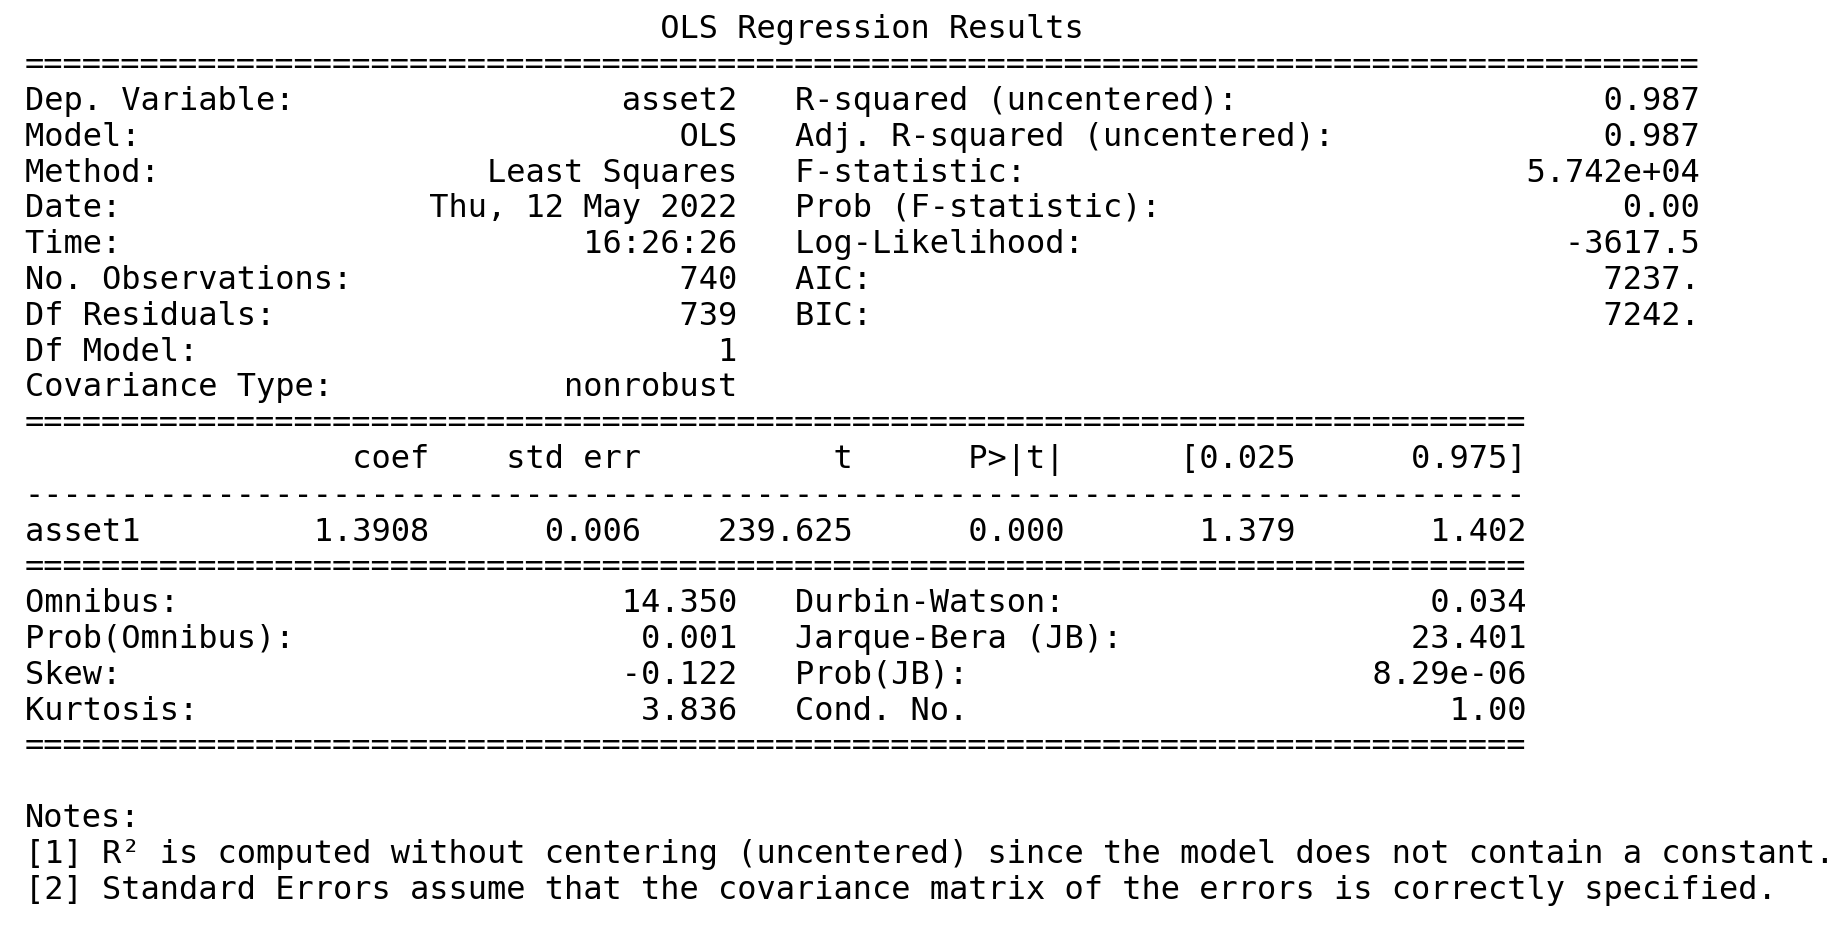

In [15]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [16]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  1.3907539154049346


In [17]:
# calculate spread
residual = train.asset2 - model.params[0] * train.asset1

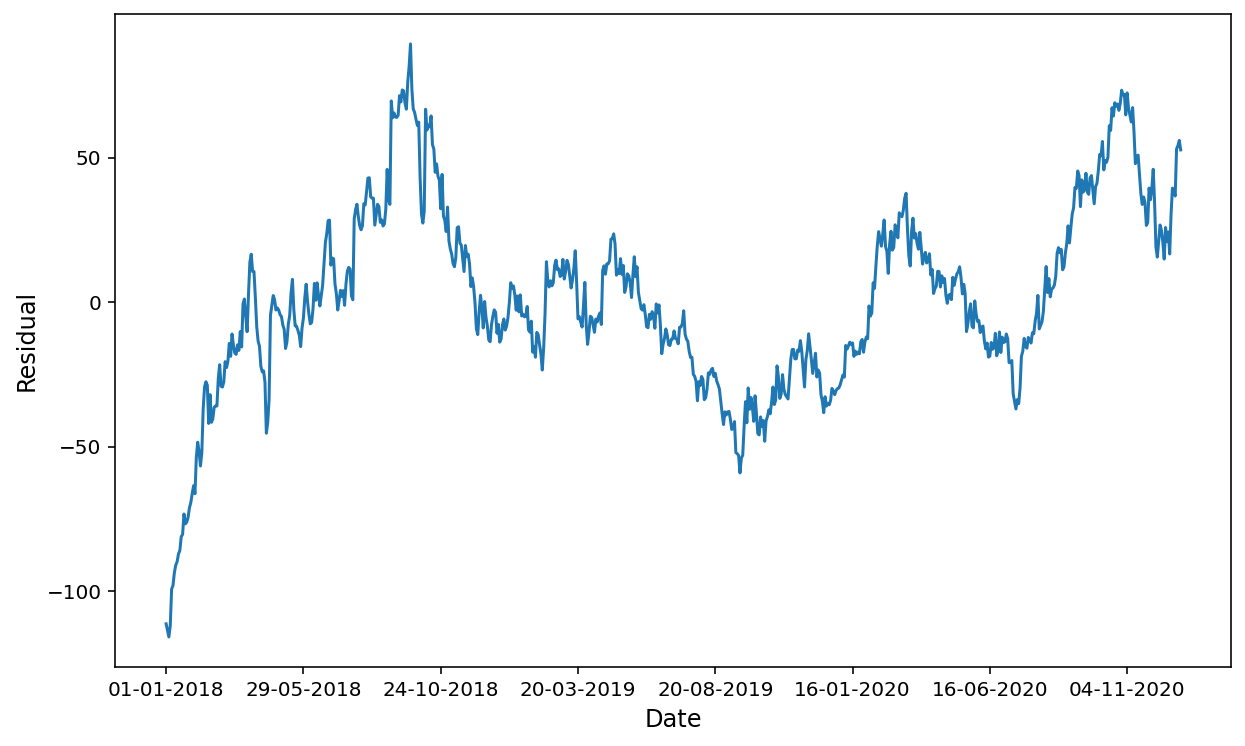

In [19]:
# Plot the residual
ax = residual.plot(figsize=(10, 6))
ax.set_ylabel("Residual", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.grid(True);
plt.savefig('chart5', dpi=500);

In [22]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(residual, maxlag = 1)
adf

(-3.482907968712014,
 0.008437058306607239,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 4705.323762449071)

In [23]:
print('Critical Value = ', adf[0])

Critical Value =  -3.482907968712014


In [24]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [25]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [26]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [27]:
signals.head()

asset1      asset2
date                              
01-01-2021  238.350006  389.700012
04-01-2021  254.300003  403.100006
05-01-2021  250.300003  395.250000
06-01-2021  259.049988  401.700012
07-01-2021  272.899994  405.399994

In [28]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [29]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  238.350006  389.700012 -0.455788            1.0           -1.0
04-01-2021  254.300003  403.100006 -0.219996            1.0           -1.0
05-01-2021  250.300003  395.250000 -0.190465            1.0           -1.0
06-01-2021  259.049988  401.700012 -0.048105            1.0           -1.0
07-01-2021  272.899994  405.399994  0.298513            1.0           -1.0

In [30]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [31]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

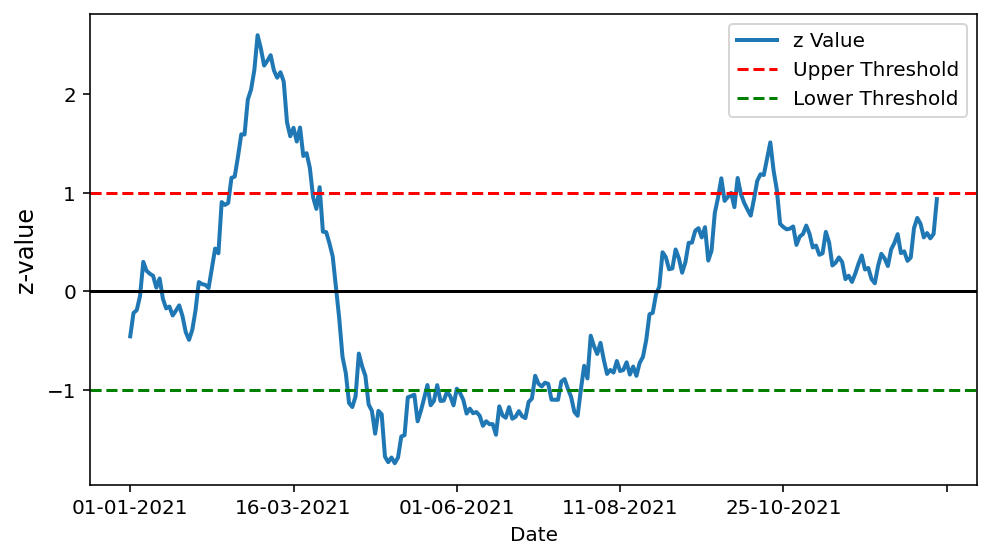

In [32]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value", figsize=(7, 4), linewidth=2)
#plt.title("Z-score Evaluation")
plt.ylabel("z-value", fontsize=12)
plt.xlabel("Date")
plt.axhline(signals['z'].mean(),linestyle= 'solid', color="black")
plt.axhline(signals['z upper limit'].mean(), linestyle= 'dashed',color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), linestyle = 'dashed', color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=500);

In [33]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  389.700012 -0.455788            1.0           -1.0   
04-01-2021  254.300003  403.100006 -0.219996            1.0           -1.0   
05-01-2021  250.300003  395.250000 -0.190465            1.0           -1.0   
29-12-2021  454.250000  655.900024  0.536278            1.0           -1.0   
30-12-2021  449.649994  645.799988  0.581734            1.0           -1.0   
31-12-2021  475.549988  655.950012  0.933656            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [34]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
16-02-2021  302.700012  407.649994  1.149018            1.0           -1.0   
17-02-2021  303.899994  408.700012  1.161623            1.0           -1.0   
18-02-2021  309.899994  407.649994  1.365511            1.0           -1.0   
19-02-2021  308.000000  395.649994  1.589270            1.0           -1.0   
22-02-2021  316.100006  406.100006  1.588215            1.0           -1.0   
23-02-2021  333.049988  412.600006  1.941457            1.0           -1.0   
24-02-2021  332.799988  408.100006  2.043049            1.0           -1.0   
25-02-2021  350.700012  421.750000  2.239769            1.0           -1.0   
26-02-2021  340.250000  395.450012  2.593727            1.0           -1.0   
01-03-2021  344.100006  405.100006  2.458989            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
16-02-2021        -1        -1.0         1         1.0  
17-02-2021        -1         0.0         1         0.0  
18-02-2021        -1         0.0         1         0.0  
19-02-2021        -1         0.0         1         0.0  
22-02-2021        -1         0.0         1         0.0  
23-02-2021        -1         0.0         1         0.0  
24-02-2021        -1         0.0         1         0.0  
25-02-2021        -1         0.0         1         0.0  
26-02-2021        -1         0.0         1         0.0  
01-03-2021        -1         0.0         1         0.0

In [35]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  389.700012 -0.455788            1.0           -1.0   
16-02-2021  302.700012  407.649994  1.149018            1.0           -1.0   
24-03-2021  317.750000  437.350006  0.952726            1.0           -1.0   
26-03-2021  327.149994  445.200012  1.054506            1.0           -1.0   
30-03-2021  326.299988  467.450012  0.603483            1.0           -1.0   
28-09-2021  478.149994  660.849976  0.915992            1.0           -1.0   
04-10-2021  505.700012  681.150024  1.147450            1.0           -1.0   
05-10-2021  495.299988  679.349976  0.983915            1.0           -1.0   
12-10-2021  498.649994  673.750000  1.119140            1.0           -1.0   
22-10-2021  470.450012  667.799988  0.682358            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
16-02-2021        -1        -1.0         1         1.0  
24-03-2021         0         1.0         0        -1.0  
26-03-2021        -1        -1.0         1         1.0  
30-03-2021         0         1.0         0        -1.0  
28-09-2021         0         1.0         0        -1.0  
04-10-2021        -1        -1.0         1         1.0  
05-10-2021         0         1.0         0        -1.0  
12-10-2021        -1        -1.0         1         1.0  
22-10-2021         0         1.0         0        -1.0

In [36]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

317.750000    1
326.299988    1
336.200012    1
355.850006    1
385.200012    1
391.200012    1
398.799988    1
388.350006    1
383.000000    1
478.149994    1
495.299988    1
470.450012    1
Name: asset1, dtype: int64

In [37]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  238.350006  389.700012 -0.455788            1.0           -1.0   
04-01-2021  254.300003  403.100006 -0.219996            1.0           -1.0   
05-01-2021  250.300003  395.250000 -0.190465            1.0           -1.0   
06-01-2021  259.049988  401.700012 -0.048105            1.0           -1.0   
07-01-2021  272.899994  405.399994  0.298513            1.0           -1.0   
...                ...         ...       ...            ...            ...   
27-12-2021  452.799988  653.049988  0.546110            1.0           -1.0   
28-12-2021  458.149994  657.349976  0.590276            1.0           -1.0   
29-12-2021  454.250000  655.900024  0.536278            1.0           -1.0   
30-12-2021  449.649994  645.799988  0.581734            1.0           -1.0   
31-12-2021  475.549988  655.950012  0.933656            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [38]:
signals = signals.reset_index()

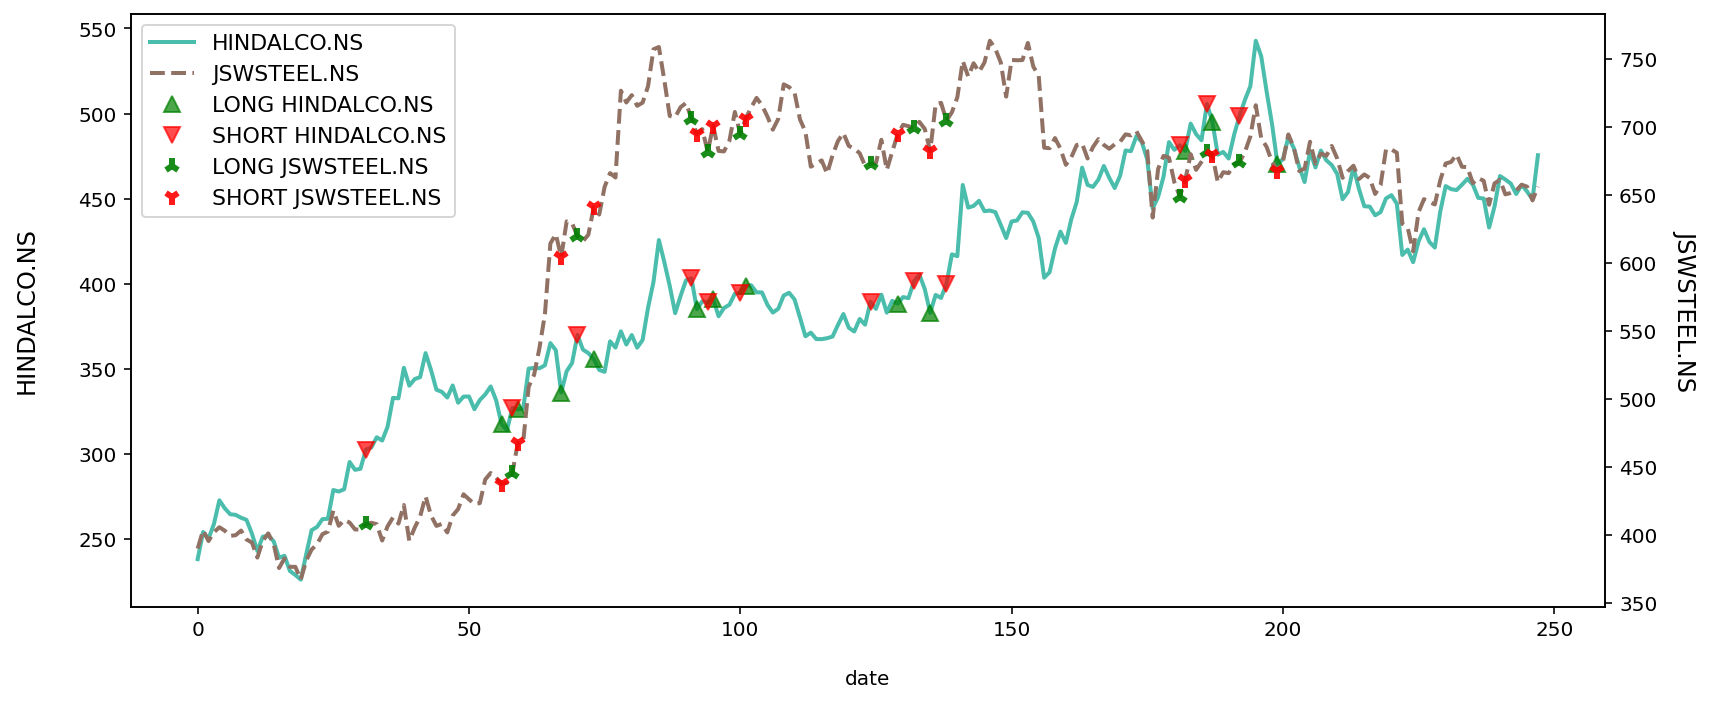

In [40]:
# visualize trading signals and position
fig=plt.figure(figsize=(12,5))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac', linestyle = 'solid', linewidth=2)
l2, = bx2.plot(signals['asset2'], c='#907163', linestyle = 'dashed', linewidth=2)

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, 
              marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,
              marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,
               marker='2',markersize=8, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,
               marker='1',markersize=8, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel(asset1,fontsize=12)
bx2.set_ylabel(asset2, rotation=270, fontsize=12)
bx.yaxis.labelpad=20
bx2.yaxis.labelpad=20
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best', fontsize = 11)

#plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date', fontsize=12)
#plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=500);

### Portfolio Profit and Loss Calculation

In [41]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [42]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [43]:
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1  return1  positions1
0    238.350006        NaN            NaN            NaN      NaN         NaN
1    254.300003        0.0  100000.000000  100000.000000      NaN         0.0
2    250.300003        0.0  100000.000000  100000.000000      0.0         0.0
3    259.049988        0.0  100000.000000  100000.000000      0.0         0.0
4    272.899994        0.0  100000.000000  100000.000000      0.0         0.0
243  452.799988        0.0  125281.593266  125281.593266      0.0         0.0
244  458.149994        0.0  125281.593266  125281.593266      0.0         0.0
245  454.250000        0.0  125281.593266  125281.593266      0.0         0.0
246  449.649994        0.0  125281.593266  125281.593266      0.0         0.0
247  475.549988        0.0  125281.593266  125281.593266      0.0         0.0

In [44]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   238.350006           NaN            NaN            NaN           NaN   
31  302.700012 -55696.802245  155696.802245  100000.000000  0.000000e+00   
56  317.750000      0.000000   97230.802245   97230.802245  2.711487e-02   
58  327.149994 -60195.598878  157426.401122   97230.802245  2.220446e-16   
59  326.299988      0.000000   97387.203367   97387.203367  1.608555e-03   

    positions1  
0          NaN  
31        -1.0  
56         1.0  
58        -1.0  
59         1.0

In [45]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [46]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1  return1  positions1  \
0    238.350006        NaN            NaN            NaN      NaN         NaN   
1    254.300003        0.0  100000.000000  100000.000000      NaN         0.0   
2    250.300003        0.0  100000.000000  100000.000000      0.0         0.0   
3    259.049988        0.0  100000.000000  100000.000000      0.0         0.0   
4    272.899994        0.0  100000.000000  100000.000000      0.0         0.0   
243  452.799988        0.0  125281.593266  125281.593266      0.0         0.0   
244  458.149994        0.0  125281.593266  125281.593266      0.0         0.0   
245  454.250000        0.0  125281.593266  125281.593266      0.0         0.0   
246  449.649994        0.0  125281.593266  125281.593266      0.0         0.0   
247  475.549988        0.0  125281.593266  125281.593266      0.0         0.0   

         asset2  holdings2          cash2   total asset2  return2  positions2  
0    389.700012        NaN            NaN            NaN      NaN         NaN  
1    403.100006        0.0  100000.000000  100000.000000      NaN         0.0  
2    395.250000        0.0  100000.000000  100000.000000      0.0         0.0  
3    401.700012        0.0  100000.000000  100000.000000      0.0         0.0  
4    405.399994        0.0  100000.000000  100000.000000      0.0         0.0  
243  653.049988        0.0  100196.492009  100196.492009      0.0         0.0  
244  657.349976        0.0  100196.492009  100196.492009      0.0         0.0  
245  655.900024        0.0  100196.492009  100196.492009      0.0         0.0  
246  645.799988        0.0  100196.492009  100196.492009      0.0         0.0  
247  655.950012        0.0  100196.492009  100196.492009      0.0         0.0

In [47]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1       return1  \
0   238.350006           NaN            NaN            NaN           NaN   
31  302.700012 -55696.802245  155696.802245  100000.000000  0.000000e+00   
56  317.750000      0.000000   97230.802245   97230.802245  2.711487e-02   
58  327.149994 -60195.598878  157426.401122   97230.802245  2.220446e-16   
59  326.299988      0.000000   97387.203367   97387.203367  1.608555e-03   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  389.700012           NaN            NaN            NaN   
31        -1.0  407.649994  53402.149201   46597.850799  100000.000000   
56         1.0  437.350006      0.000000  103890.701598  103890.701598   
58        -1.0  445.200012  58321.201598   45569.500000  103890.701598   
59         1.0  467.450012      0.000000  106805.451598  106805.451598   

     return2  positions2  
0        NaN         NaN  
31  0.000000         1.0  
56 -0.005580        -1.0  
58  0.000000         1.0  
59  0.028056        -1.0

In [48]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

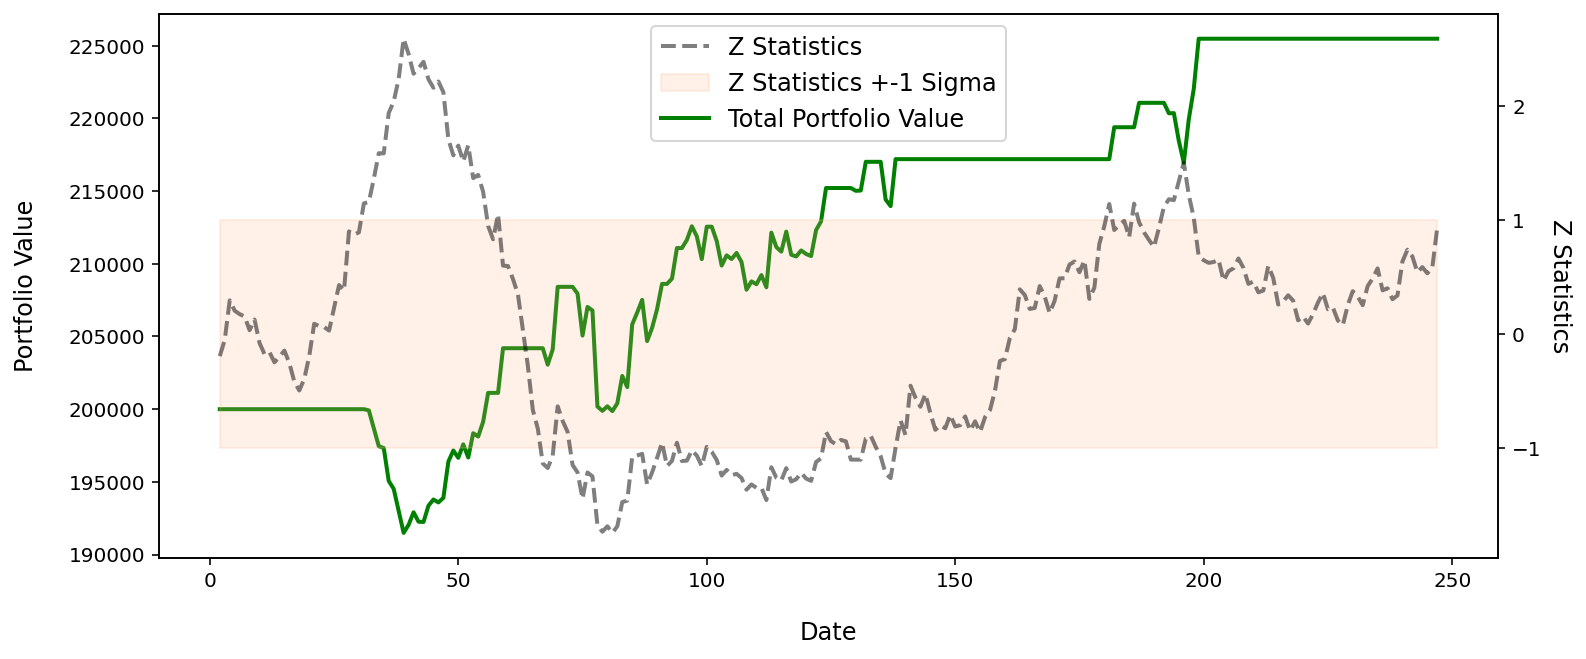

In [51]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(12,5),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g', linewidth = 2, linestyle='solid')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.5, linewidth = 2, 
               linestyle='dashed')

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value', fontsize=12)
ax2.set_ylabel('Z Statistics',rotation=270, fontsize=12)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.labelpad=15
#plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper center', fontsize=12);
plt.savefig('chart8', dpi=500);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

225478.08527460002

In [46]:
profit = final_portfolio - 2*initial_capital
profit

25478.085274600016

In [48]:
roi = (profit/(2*initial_capital))*100 # computation of the overall ROI of the pair trading strategy
roi

12.739042637300008

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 235.779%
